In [18]:
!pip install missingno
!pip install plotly
!pip install minisom
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install -q -U scikit-learn imblearn xgboost catboost lightgbm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 28.3 MB/s eta 0:00:00


## Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import missingno as msno
from collections import OrderedDict

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, auc, roc_auc_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, classification_report)

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier




# plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9,6)
RANDOM_STATE = 42
warnings.filterwarnings("ignore")

### Load data  

In [22]:
!curl -L -o datasets-for-churn-telecom.zip https://www.kaggle.com/api/v1/datasets/download/jpacse/datasets-for-churn-telecom

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4009k  100 4009k    0     0  5177k      0 --:--:-- --:--:-- --:--:-- 11.9M


### Load from kaggle

In [ ]:
!unzip datasets-for-churn-telecom.zip

In [ ]:
df_test = pd.read_csv("/kaggle/input/datasets-for-churn-telecom/cell2cellholdout.csv")
df_test

In [ ]:
df_train = pd.read_csv("/kaggle/input/datasets-for-churn-telecom/cell2celltrain.csv")
df_train

In [ ]:
print("\nLOADING DATA...")
data_path = 'cell2celltrain.csv'
df = pd.read_csv(data_path)
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Form analysis:

## Target identification:

In [ ]:
pd.set_option('display.max_columns',50)

Our target variable is the “churn” column because our goal is to build a Real-Time Customer Churn Prediction System.

## Analyse the board

In [ ]:
df_train.shape

In [ ]:
df_1 = df_train.copy()

So here we have 51047 rows and 58 columbs

<Axes: title={'center': 'Data Types Distribution'}, ylabel='count'>

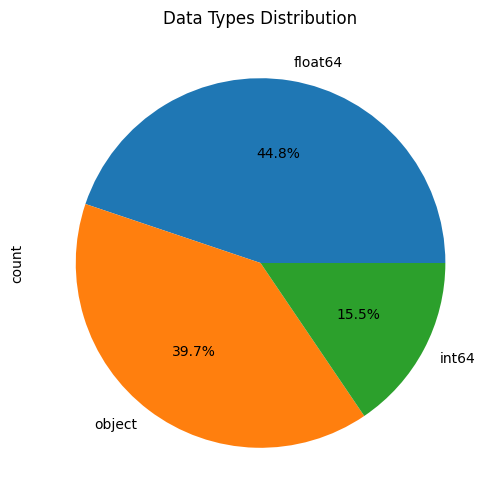

In [ ]:
type_counts = df_1.dtypes.value_counts()

type_counts.plot.pie(autopct='%1.1f%%', figsize=(6,6), title='Data Types Distribution')

We have a table containing three types of variables: int64, float64, and object. There are more qualitative variables than quantitative variables.

Only the column with object types:

In [ ]:
df_obj = df_1.select_dtypes(include='object')
df_obj.head()

,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,Yes,SEAPOR503,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,No,No,No,30,Yes,1-Highest,Suburban,Professional,No
1,Yes,PITHOM412,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,Yes,No,No,30,No,4-Medium,Suburban,Professional,Yes
2,No,MILMIL414,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,Yes,No,No,Unknown,No,3-Good,Town,Crafts,Yes
3,No,PITHOM412,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,Yes,No,No,10,No,4-Medium,Other,Other,No
4,Yes,OKCTUL918,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,No,Yes,No,10,No,1-Highest,Other,Professional,Yes


In [ ]:
df_num = df_1.select_dtypes(include=['int64', 'float64'])
df_num.head()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
0,3000002,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,2.0,2.0,361.0,62.0,0.0,1,0,0,4,0
1,3000010,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,2.0,1.0,1504.0,40.0,42.0,0,0,0,5,0
2,3000014,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,1.0,1.0,1812.0,26.0,26.0,0,0,0,6,0
3,3000022,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,9.0,4.0,458.0,30.0,0.0,0,0,0,6,0
4,3000026,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,4.0,3.0,852.0,46.0,54.0,0,0,0,9,1


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [ ]:
df_1.describe()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,5.104700e+04,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50891.000000,50680.000000,50680.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000,51046.000000,51046.000000,51046.000000,50138.000000,50138.000000,51047.000000,51047.000000,51047.000000,51047.000000,51047.000000
mean,3.201957e+06,58.834492,525.653416,46.830088,0.895229,40.027785,1.236244,-11.547908,-1.191985,6.011489,4.085672,28.288981,1.868999,0.298838,114.800121,25.377715,8.178104,90.549515,67.650790,10.158003,0.012277,1.840504,18.756264,1.532157,1.354340,1.805646,1.558751,380.545841,31.338127,21.144142,0.037201,0.018277,0.052070,4.324524,0.053911
std,1.169056e+05,44.507336,529.871063,23.848871,2.228546,96.588076,9.818294,257.514772,39.574915,9.043955,10.946905,38.876194,5.096138,1.168277,166.485896,35.209147,16.665878,104.947470,92.752699,15.555284,0.594168,5.585129,9.800138,1.223384,0.675477,1.331173,0.905932,253.801982,22.094635,23.931368,0.206483,0.142458,0.307592,3.138236,0.383147
min,3.000002e+06,-6.170000,0.000000,-11.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100632e+06,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.100000,0.700000,0.000000,5.300000,0.000000,0.000000,8.300000,3.300000,0.000000,23.000000,11.000000,1.700000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.201534e+06,48.460000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,1.000000,16.300000,0.000000,0.000000,52.800000,13.700000,2.000000,62.000000,35.700000,5.300000,0.000000,0.300000,16.000000,1.000000,1.000000,1.000000,1.000000,329.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.305376e+06,71.065000,723.000000,60.000000,0.990000,41.000000,0.300000,66.000000,1.600000,7.700000,3.700000,36.300000,1.700000,0.300000,153.500000,34.000000,9.300000,121.300000,88.700000,12.300000,0.000000,1.300000,24.000000,2.000000,2.000000,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399994e+06,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,384.300000,848.700000,327.300000,66.000000,2692.400000,644.300000,519.300000,2090.700000,1474.700000,411.700000,81.300000,212.700000,61.000000,196.000000,53.000000,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,35.000000,9.000000,25.000000


Let's look of the duplicated data

In [ ]:
df_1.duplicated().sum()


0

Let's remove the Customer ID column from the EDA, as it does not provide any useful information.

In [ ]:
df_2 = df_1.drop(columns="CustomerID", axis=1)
df_2.shape

(51047, 57)

## Analyse target:

In [ ]:
df_1['Churn'].describe()

count     51047
unique        2
top          No
freq      36336
Name: Churn, dtype: object

We can see the positive and negative classes are imbalanced with approximately 70% of clients who have not churned.



In [ ]:
df_1['Churn'] = df_1['Churn'].replace(to_replace = ['Yes', 'No'], value = [1, 0])

value_counts_churn = df_1['Churn'].value_counts(dropna = False).sort_values()
value_counts_churn

Churn
1    14711
0    36336
Name: count, dtype: int64

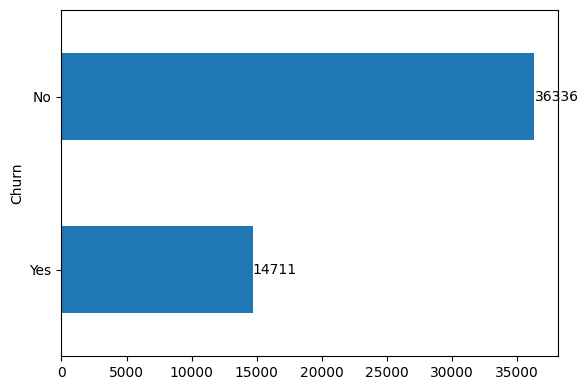

In [ ]:
value_counts_churn = df_1['Churn'].value_counts(dropna=False).sort_values()

ax = value_counts_churn.plot(kind='barh', figsize=(6,4))
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

## Correlations

### Let's see the number of columns who contains the objetc and numerical values

In [ ]:
o = df_1.dtypes == "object"
obj_cols = list(o[o].index)
len(obj_cols)

22

In [ ]:
s = df_1.dtypes!="object"
num_cols = list(s[s].index)
len(num_cols)

36

### Correlation between numericals values

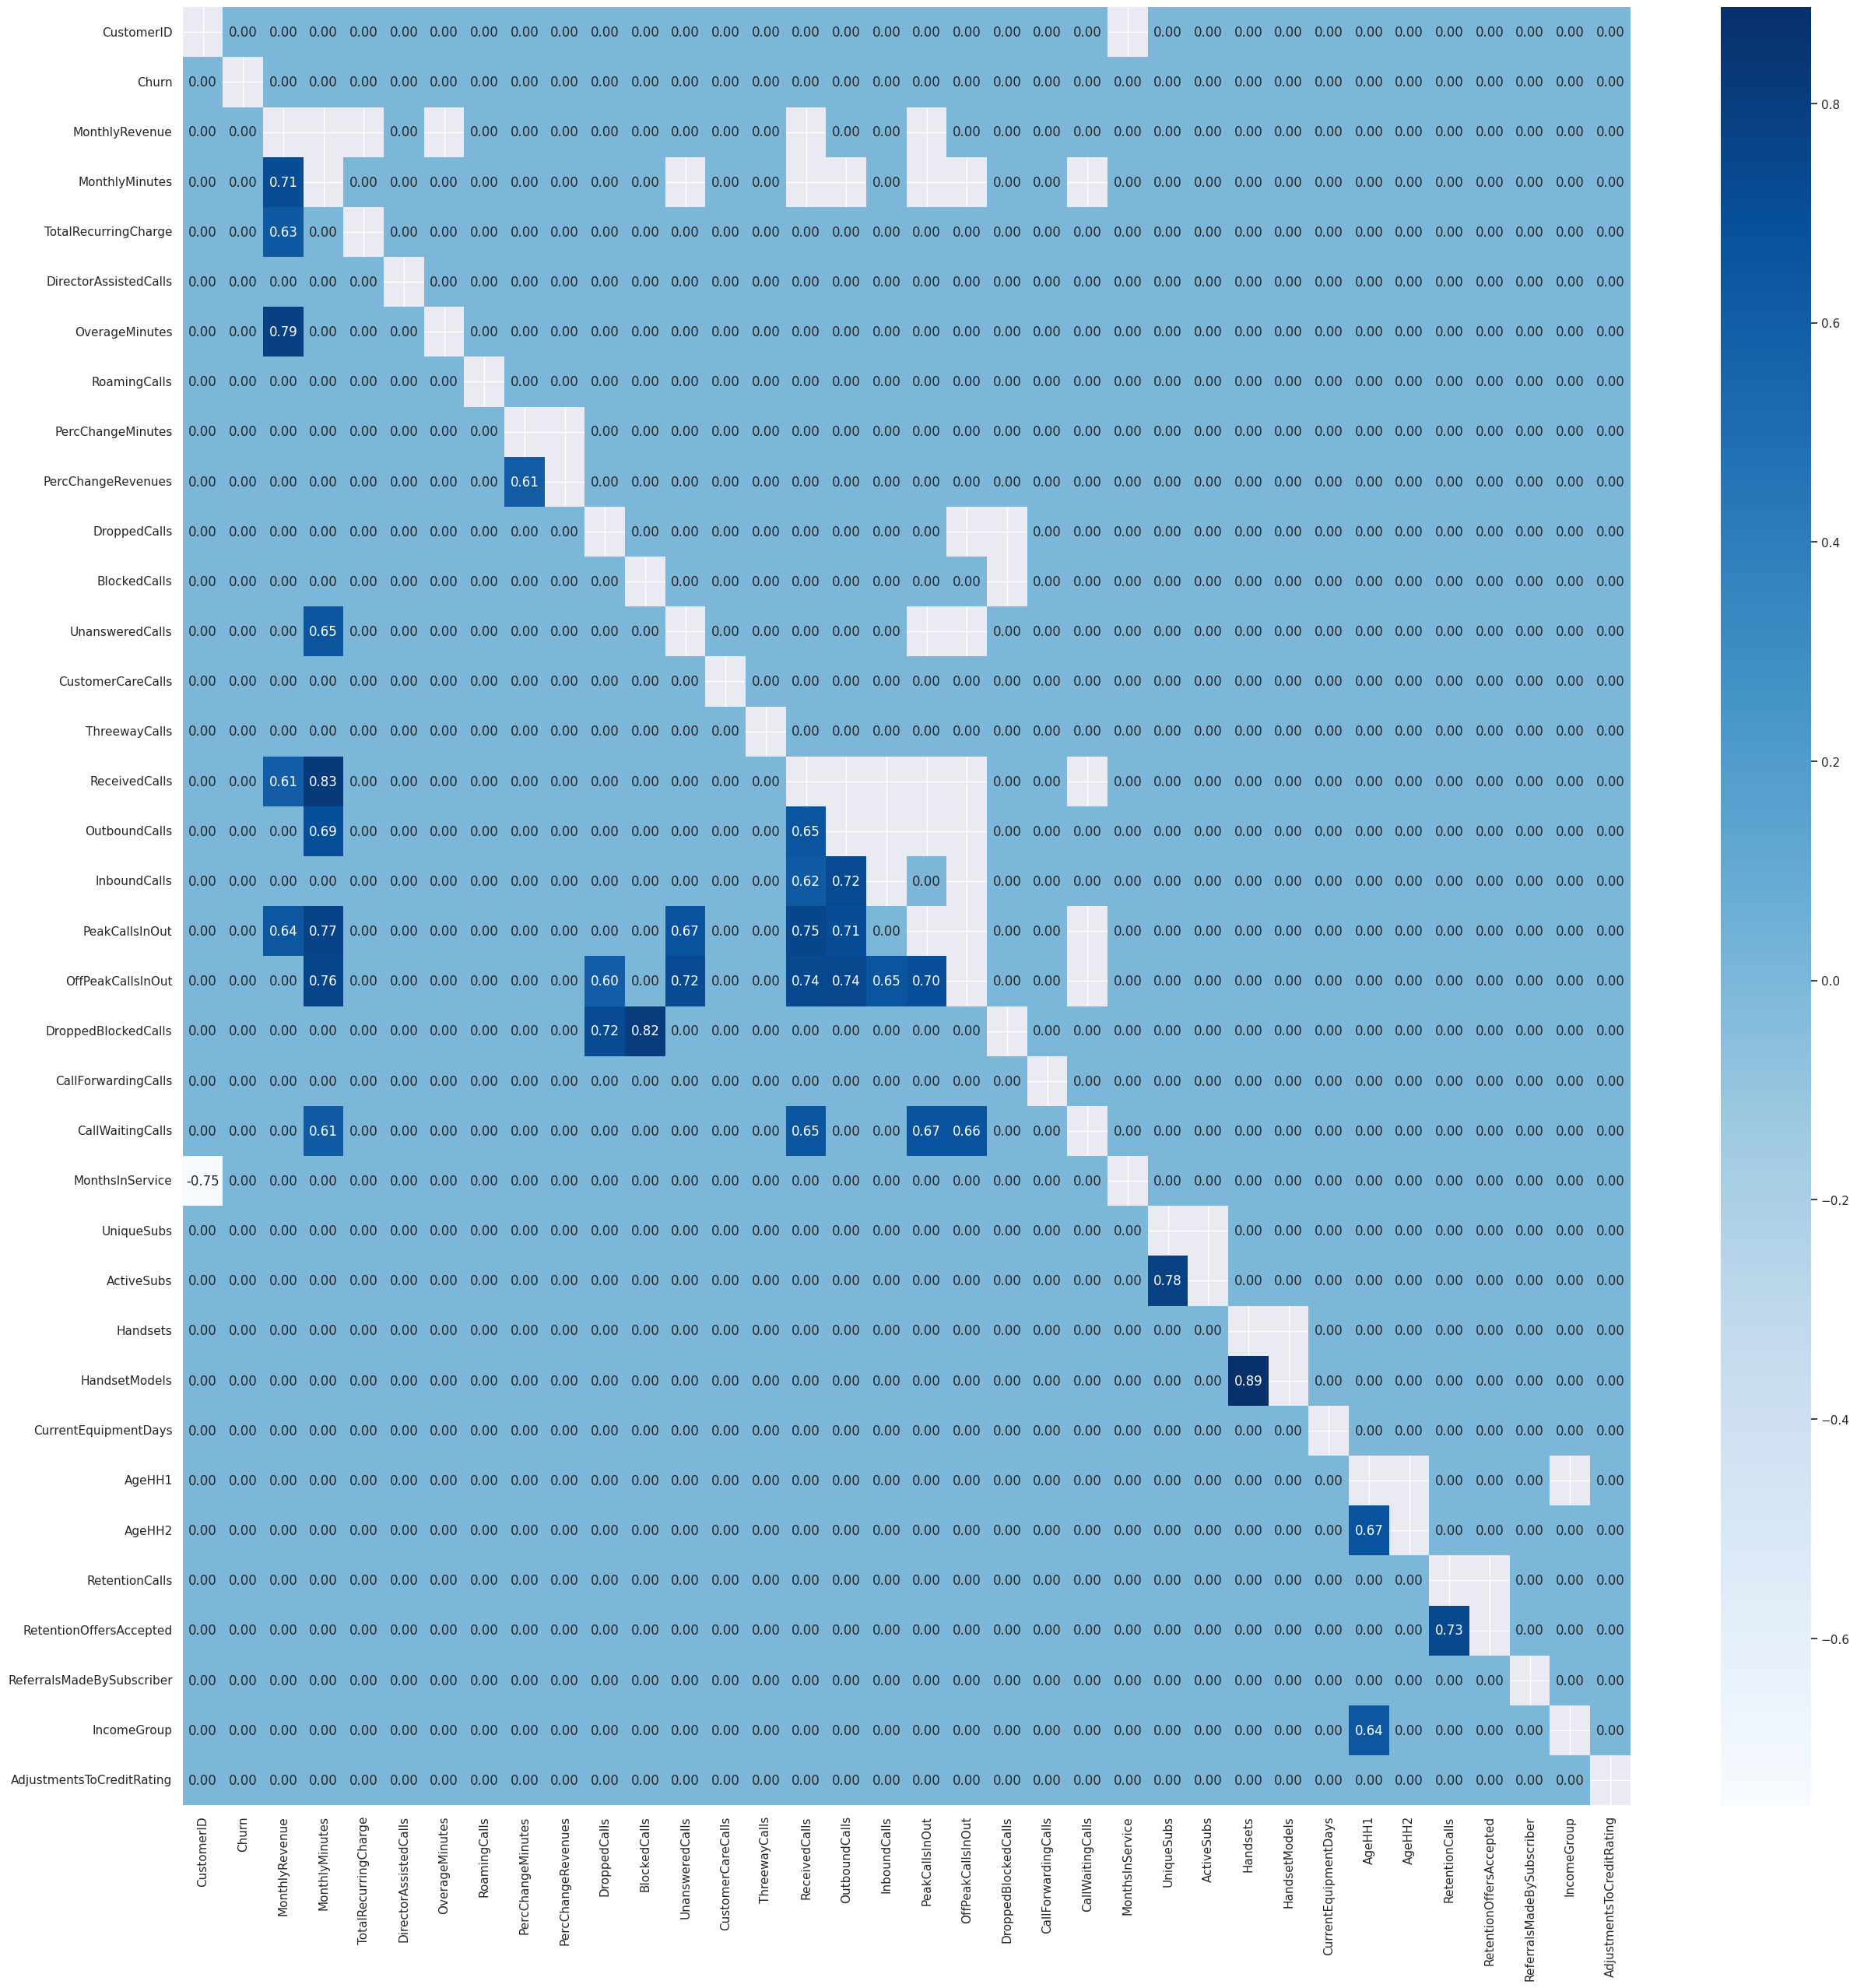

In [ ]:
sns.set(rc={'figure.figsize':(30,30)})
corr= df_1[num_cols].corr()
corr = corr[abs(corr)>=0.6].fillna(0)

matrix = np.triu(corr)
s
sns.heatmap(corr, annot=True, mask=matrix, fmt='.2f', cmap="Blues")

plt.savefig("strong correlations.jpeg")
plt.show()

## Analysis of missing values

In [ ]:
df_nan= df_2[df_2.isna().any(axis=1)]
df_nan.head()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,...,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
62,Yes,90.25,952.0,50.0,0.00,161.0,0.0,308.0,51.2,11.7,1.3,47.3,0.0,0.0,464.2,8.3,7.3,300.0,95.0,13.0,0.0,10.3,54,1,1,...,No,No,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,0,No,0,30,No,6-VeryLow,Other,Other,Unknown
87,No,122.00,1806.0,75.0,15.59,146.0,1.0,-156.0,-32.8,5.0,14.0,62.7,2.0,0.7,409.9,50.0,13.0,290.3,147.7,19.0,0.0,14.7,49,2,1,...,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,0,No,0,30,No,6-VeryLow,Suburban,Other,Unknown
91,No,96.04,545.0,60.0,0.66,111.0,1.1,NaN,NaN,3.3,0.0,21.0,0.0,0.0,38.2,12.0,1.3,52.3,40.0,3.3,0.0,0.7,53,2,1,...,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,Yes,0,0,No,0,60,No,1-Highest,Town,Other,Unknown
122,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,2,2,...,Yes,No,No,No,Known,No,Yes,No,No,No,Yes,0,0,No,Yes,0,5,No,0,30,No,1-Highest,Other,Other,No
126,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,1,1,...,No,No,No,No,Unknown,Yes,Yes,No,No,No,No,0,0,No,Yes,0,1,No,0,30,No,1-Highest,Town,Other,Unknown


We use this method because plotting the entire DataFrame would be time-consuming and impractical, as it would be difficult to visualize the missing values across more than 51,000 records.But to well see it let's see all the columns who contains the missing values



In [ ]:
nan_cols = df_2.columns[df_2.isna().any()].tolist()
nan_cols

['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2']

In [ ]:
df_2[nan_cols].isnull().sum().sort_values(ascending=False)

AgeHH1                   909
AgeHH2                   909
PercChangeMinutes        367
PercChangeRevenues       367
MonthlyRevenue           156
MonthlyMinutes           156
TotalRecurringCharge     156
DirectorAssistedCalls    156
OverageMinutes           156
RoamingCalls             156
ServiceArea               24
Handsets                   1
HandsetModels              1
CurrentEquipmentDays       1
dtype: int64

### Data cleaning ###

In [ ]:
df_1['MonthlyRevenue'] = df_1['MonthlyRevenue'].fillna(df_1['MonthlyRevenue'].median())
df_1['MonthlyMinutes'] = df_1['MonthlyMinutes'].fillna(df_1['MonthlyMinutes'].median())
df_1['TotalRecurringCharge'] = df_1['TotalRecurringCharge'].fillna(df_1['TotalRecurringCharge'].median())
df_1['DirectorAssistedCalls'] = df_1['DirectorAssistedCalls'].fillna(df_1['DirectorAssistedCalls'].median())
df_1['OverageMinutes'] = df_1['OverageMinutes'].fillna(df_1['OverageMinutes'].median())
df_1['RoamingCalls'] = df_1['RoamingCalls'].fillna(df_1['RoamingCalls'].median())
df_1['PercChangeMinutes'] = df_1['PercChangeMinutes'].fillna(df_1['PercChangeMinutes'].median())
df_1['PercChangeRevenues'] = df_1['PercChangeRevenues'].fillna(df_1['PercChangeRevenues'].median())
df_1['AgeHH1'] = df_1['AgeHH1'].fillna(df_1['AgeHH1'].median())
df_1['AgeHH2'] = df_1['AgeHH2'].fillna(df_1['AgeHH2'].median())
df_1['Handsets'] = df_1['Handsets'].fillna(df_1['Handsets'].median())
df_1['HandsetModels'] = df_1['HandsetModels'].fillna(df_1['HandsetModels'].median())
df_1['CurrentEquipmentDays'] = df_1['CurrentEquipmentDays'].fillna(df_1['CurrentEquipmentDays'].median())

df_1['ServiceArea'] = df_1['ServiceArea'].fillna(df_1['ServiceArea'].mode()[0])


In [ ]:
df_1.drop(['Churn'], axis = 1).isna().sum().sum()

0

## Categorical Data


In [ ]:
df_3 = df_2.copy()

Earlier, we saw that there are 23 object-type columns. Let's now explore them in detail.

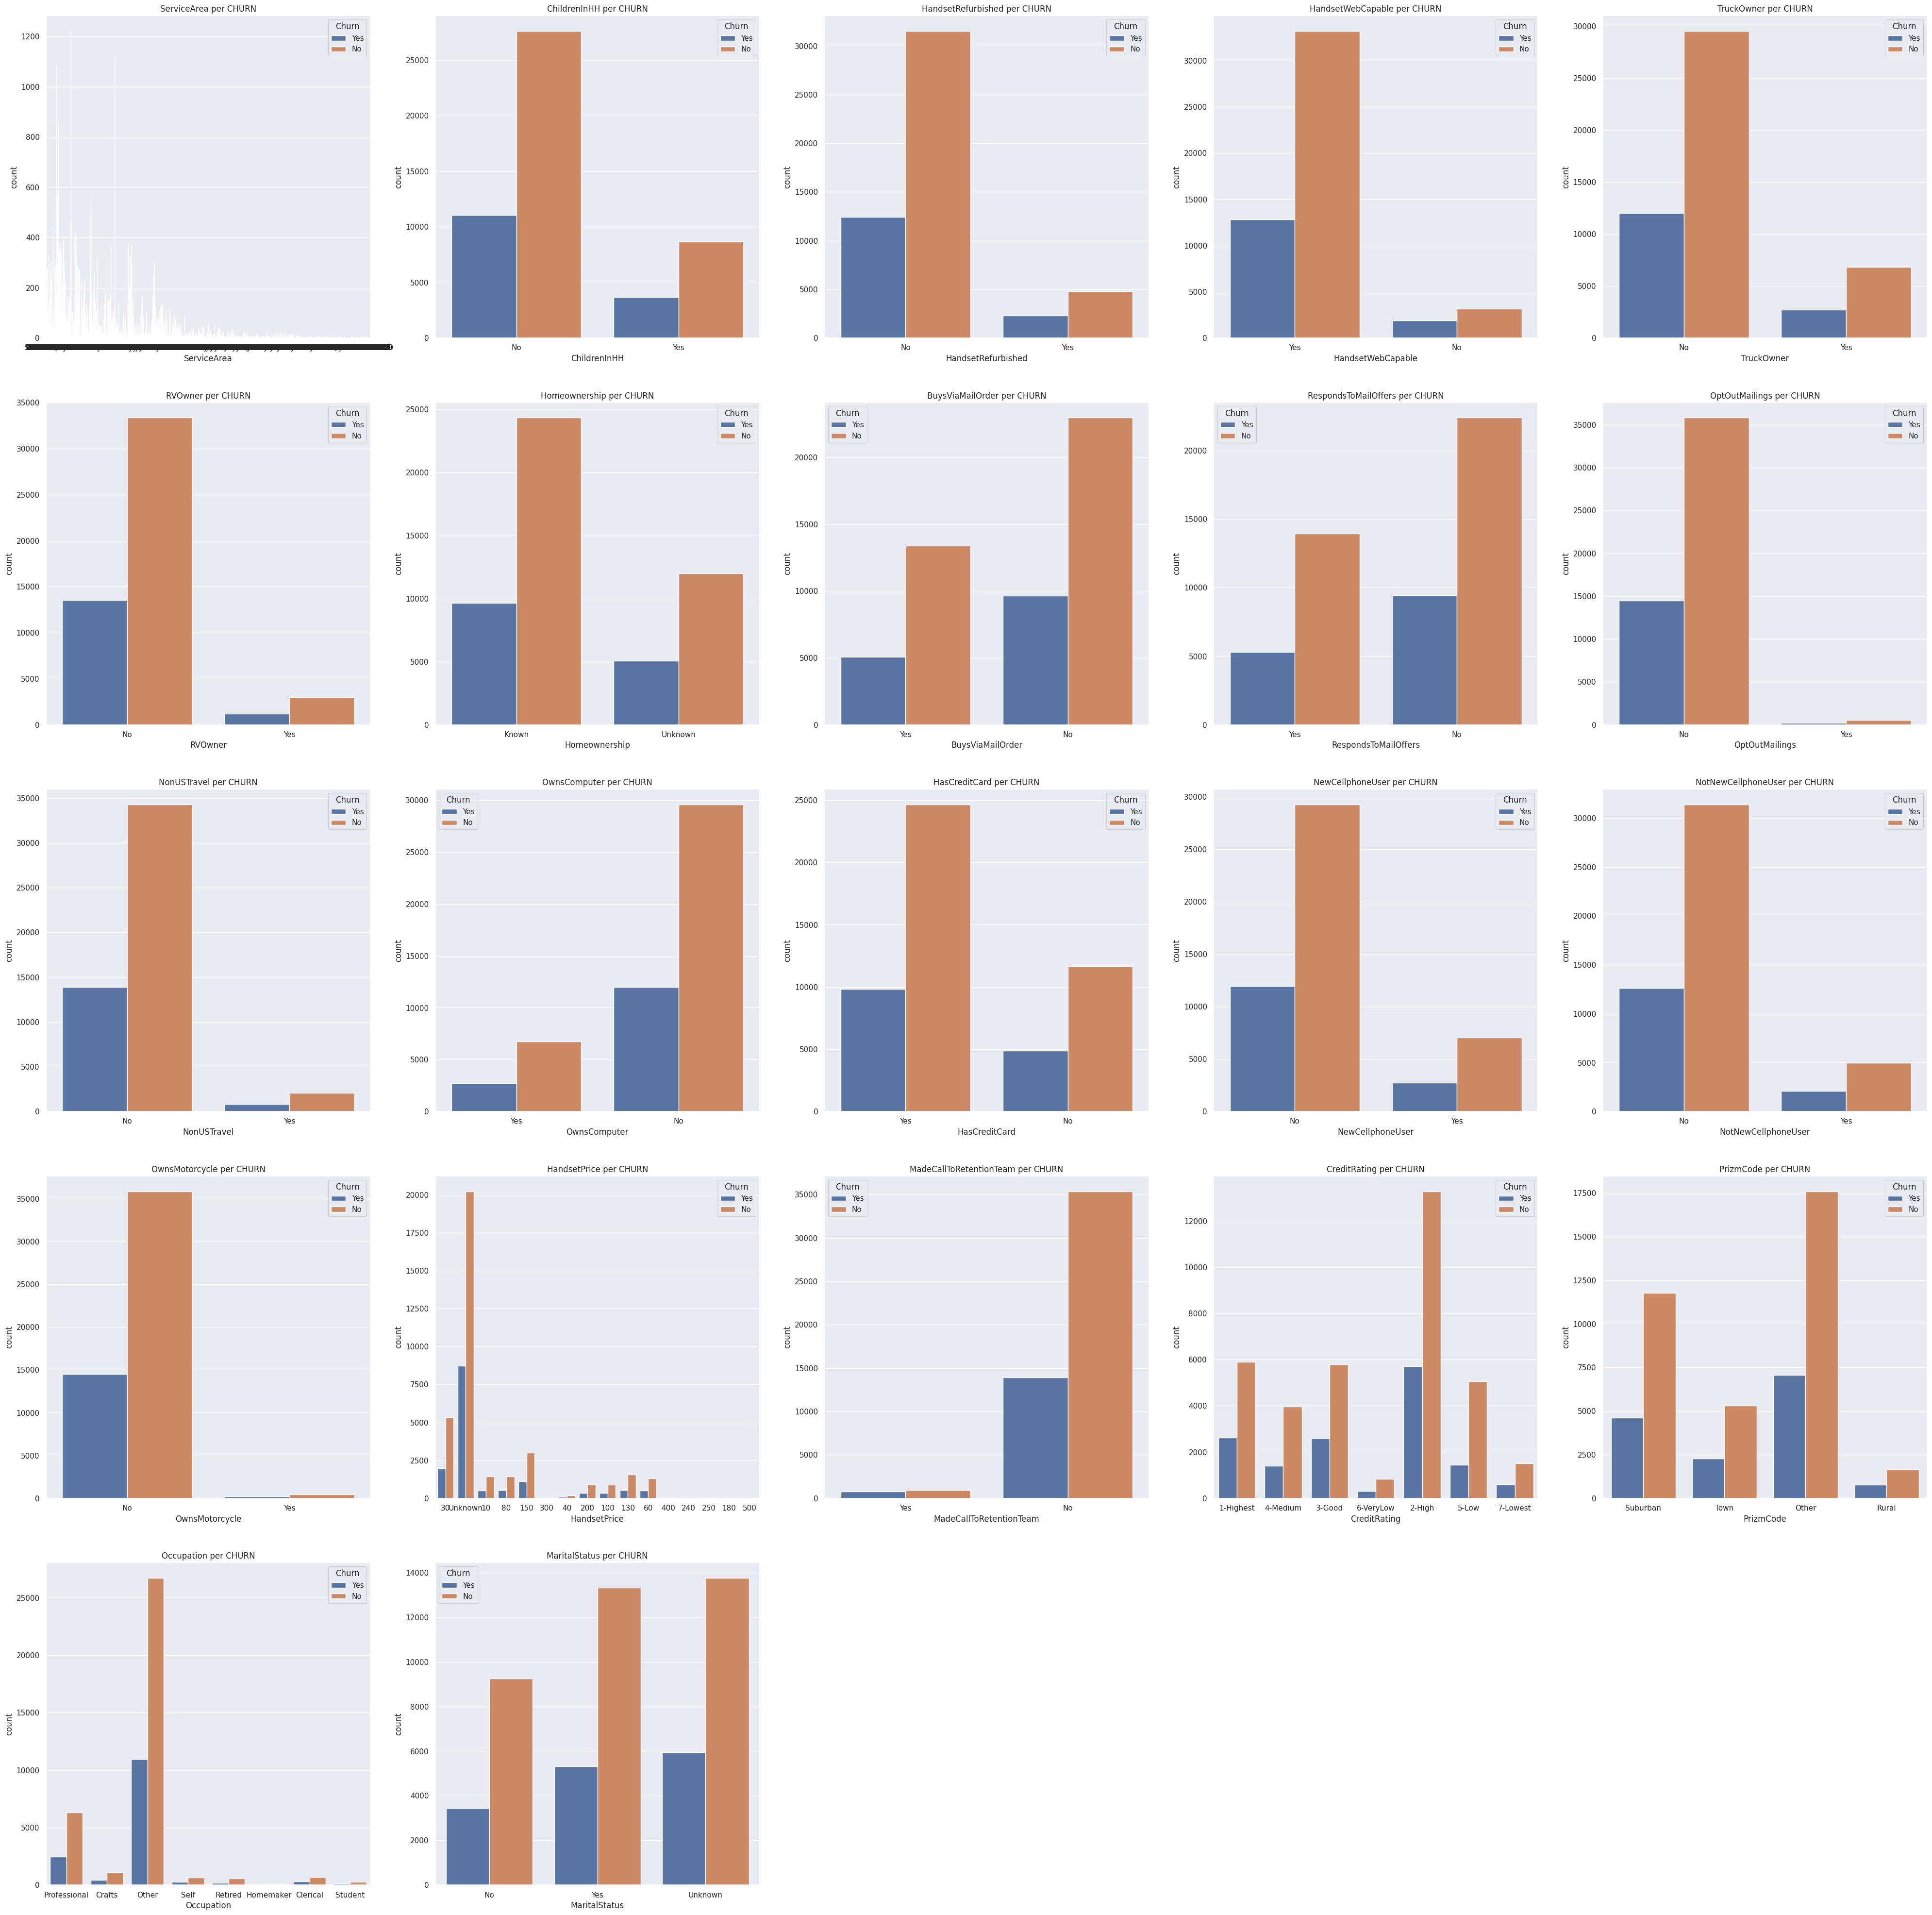

In [ ]:
sns.set(rc={'figure.figsize':(50,50)})
for i, column in enumerate(list(obj_cols), 1):
    plt.subplot(5,5,i)
    plt.title(str(column)+" per CHURN")
    p=sns.countplot(data=df_3, x=column, hue="Churn",)

plt.show()

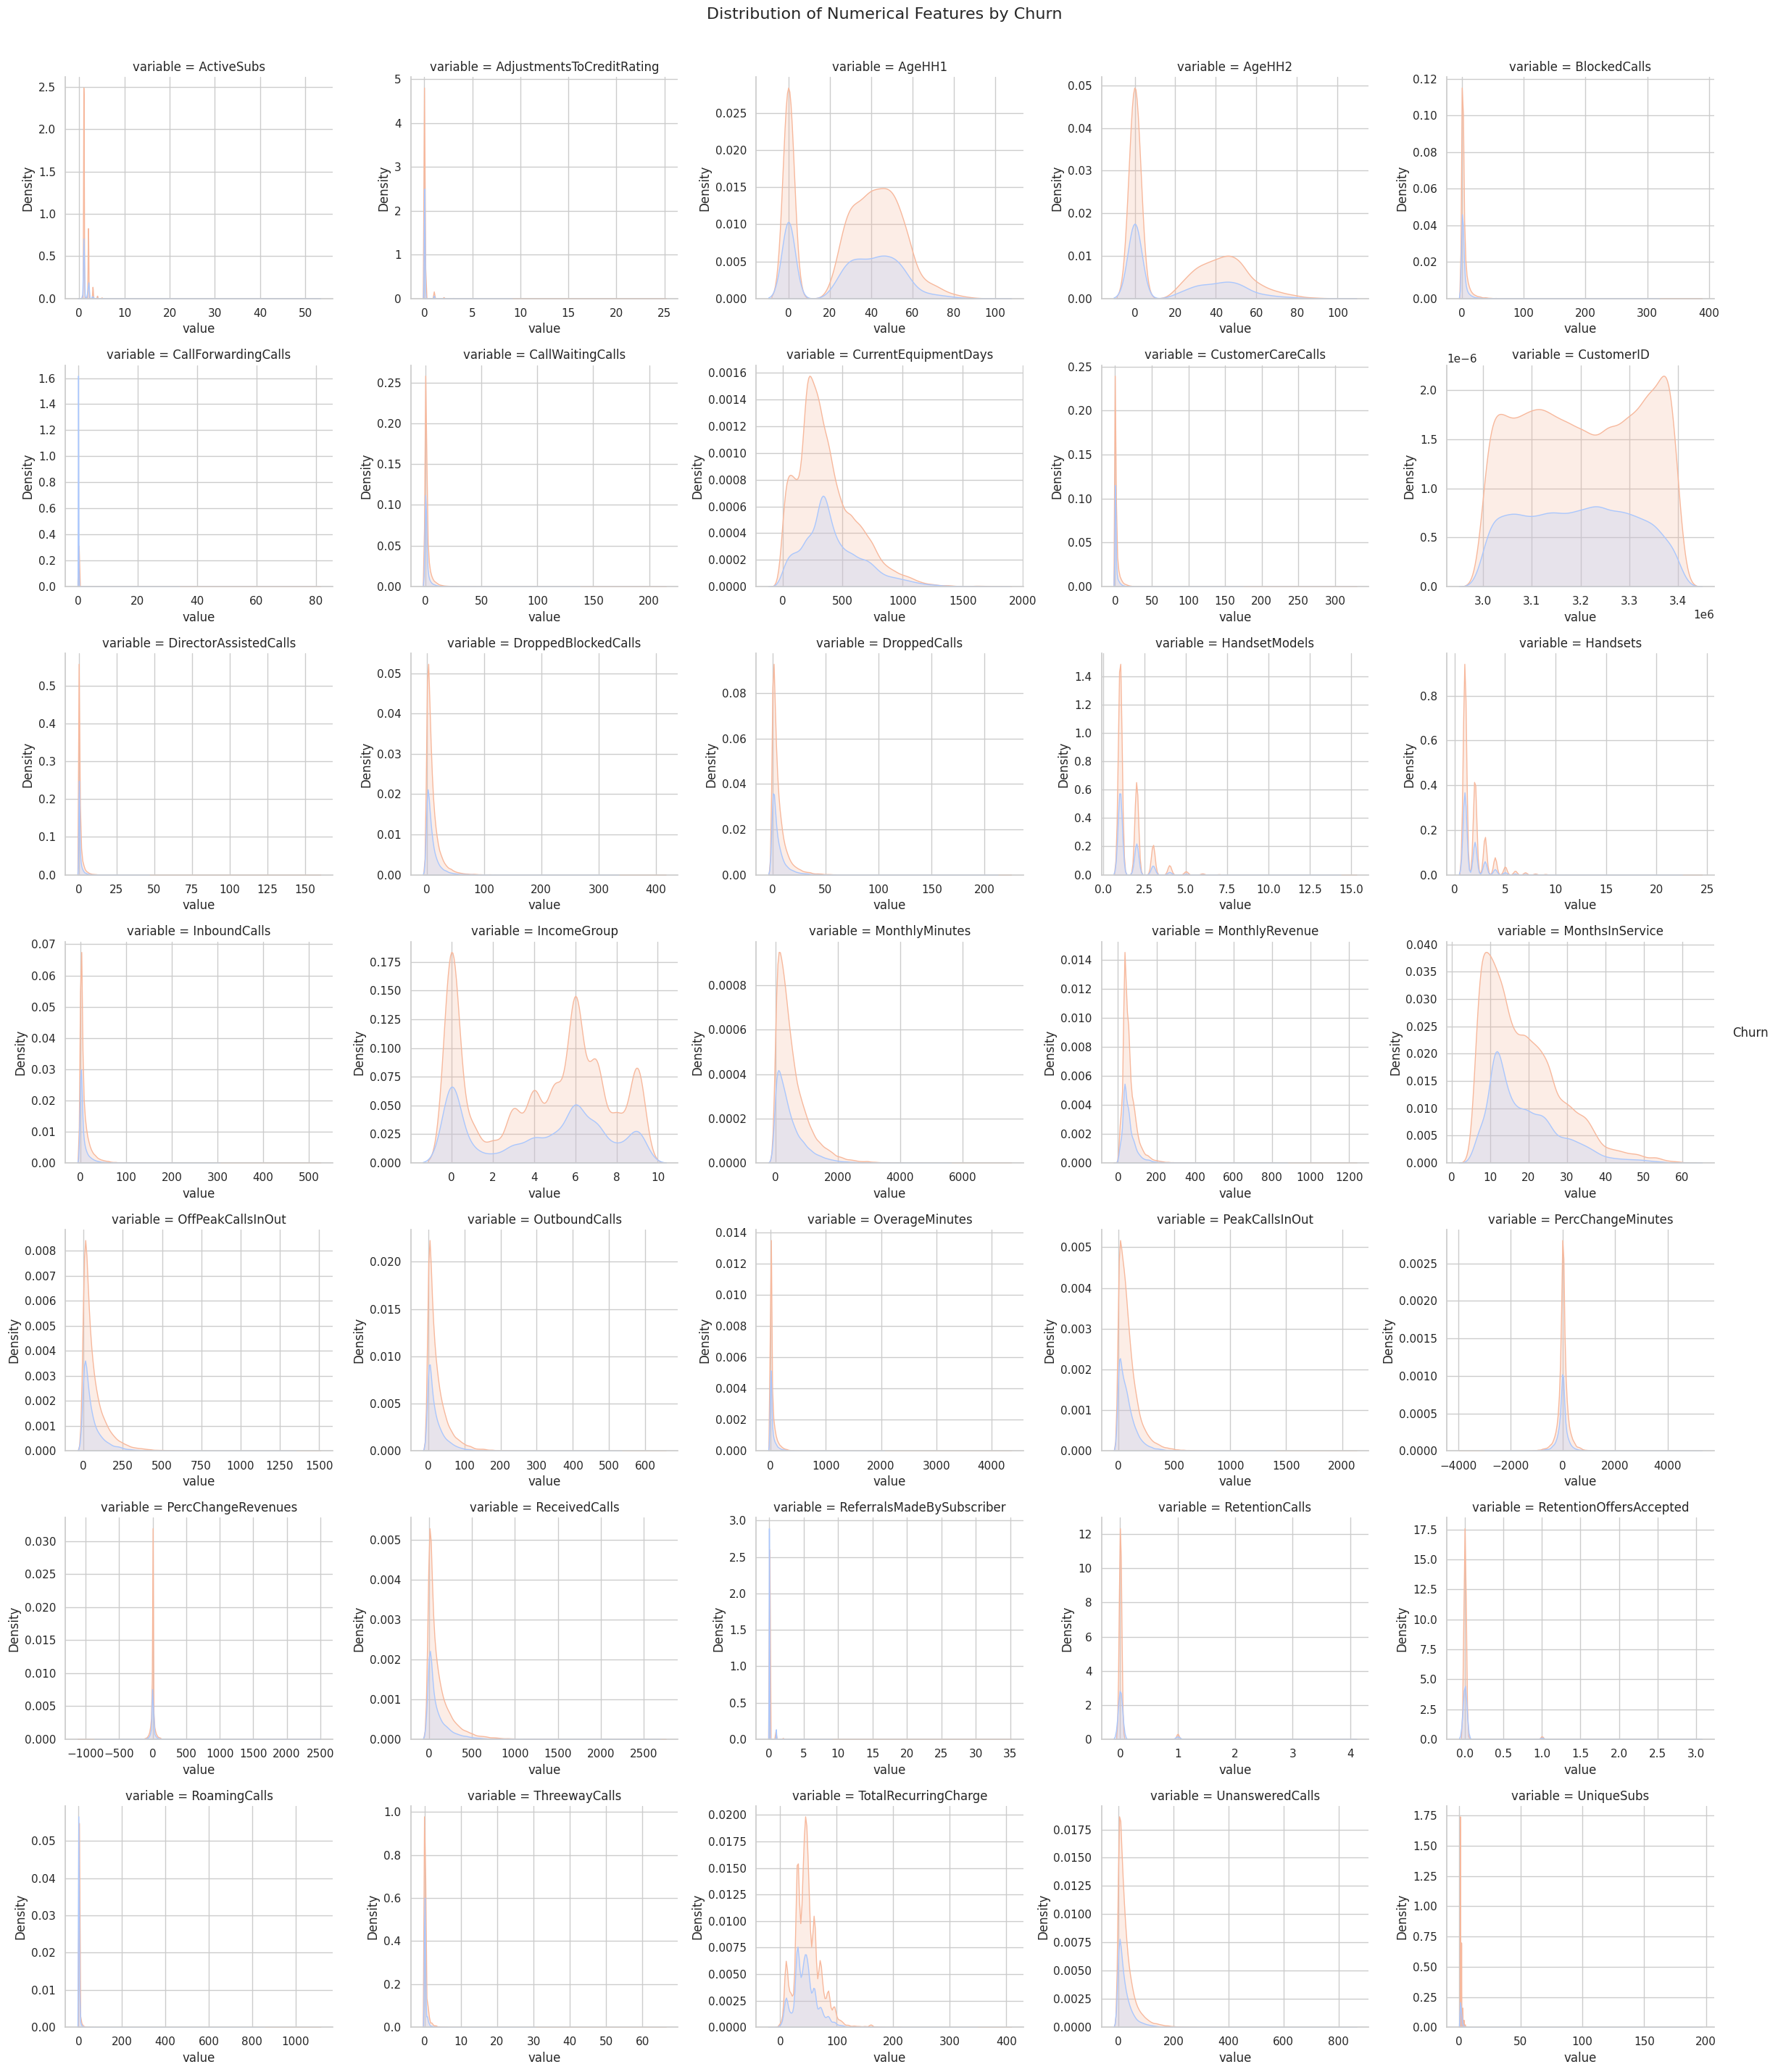

In [13]:
def plot_kde(data, **kwargs):
    sns.kdeplot(data=data, x="value", hue="Churn", fill=True, palette='coolwarm', **kwargs)

grid = sns.FacetGrid(
    df[num_cols.union(["Churn"])].melt(id_vars="Churn"),
    col="variable",
    col_wrap=5,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.2,
)

grid.map_dataframe(plot_kde)

grid.fig.suptitle("Distribution of Numerical Features by Churn", y=1.02, fontsize=16)
grid.add_legend(title="Churn")

plt.show()

## Statistical test

In [11]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

### Mutual information with Churn

In [25]:
df_temp = df.copy()

df_temp["Churn"] = df_temp["Churn"].map({'Yes': 1, 'No': 0})

for col in df_temp.drop(["CustomerID", "Churn"], axis=1).columns:
    if col in cat_cols:
        df_temp[col] = df_temp[col].fillna(df_temp[col].mode()[0])
        df_temp[col] = OrdinalEncoder().fit_transform(df_temp[col].to_numpy().reshape(-1, 1))
    else:
        df_temp[col] = df_temp[col].fillna(df_temp[col].median())

mutual_info = mutual_info_classif(df_temp.drop(["CustomerID", "Churn"], axis=1), df_temp["Churn"])

mutual_info = pd.Series(mutual_info, index=df_temp.drop(["CustomerID", "Churn"], axis=1).columns, name="Mutual Information")
mutual_info = mutual_info.sort_values(ascending=False)
display(mutual_info)

,Mutual Information
MonthsInService,0.016425
CurrentEquipmentDays,0.014959
MonthlyMinutes,0.008482
InboundCalls,0.006494
HandsetWebCapable,0.005752
ActiveSubs,0.004657
ServiceArea,0.004269
UniqueSubs,0.004242
CreditRating,0.003931
OutboundCalls,0.003708


The results show that MonthsInService and CurrentEquipmentDays have the highest mutual information with churn, meaning they are the most informative features for predicting customer churn. Most other variables have very low or zero MI, indicating weak or no relationship with churn.

### Calcul Information values with churn

In [27]:
def calculate_iv(dataset, feature, target):
    iv_df = pd.DataFrame({feature: dataset[feature], target: dataset[target]})

    iv_df = iv_df.groupby(feature)[target].agg(['count', 'sum']).reset_index()
    iv_df.columns = [feature, 'Total', 'Churn_Count']

    iv_df['Non_Churn_Count'] = iv_df['Total'] - iv_df['Churn_Count']

    iv_df['Pct_Churn'] = iv_df['Churn_Count'] / iv_df['Churn_Count'].sum()
    iv_df['Pct_Non_Churn'] = iv_df['Non_Churn_Count'] / iv_df['Non_Churn_Count'].sum()

    iv_df['Pct_Churn'] = iv_df['Pct_Churn'].replace(0, 1e-6)
    iv_df['Pct_Non_Churn'] = iv_df['Pct_Non_Churn'].replace(0, 1e-6)

    iv_df['WOE'] = np.log(iv_df['Pct_Non_Churn'] / iv_df['Pct_Churn'])
    iv_df['IV'] = (iv_df['Pct_Non_Churn'] - iv_df['Pct_Churn']) * iv_df['WOE']

    feature_iv = iv_df['IV'].sum()

    return feature_iv

iv_scores = {}

for col in cat_cols.drop(["Churn"]):
    iv_scores[col] = calculate_iv(df_temp, col, 'Churn')

iv_scores_series = pd.Series(iv_scores, name="Information Value").sort_values(ascending=False)

print("\nInformation Value (IV) Scores:")
display(iv_scores_series)


Information Value (IV) Scores:


,Information Value
ServiceArea,1.221641e-01
CreditRating,2.163721e-02
MadeCallToRetentionTeam,1.982996e-02
HandsetWebCapable,1.763622e-02
HandsetPrice,6.884936e-03
HandsetRefurbished,4.256761e-03
MaritalStatus,3.535557e-03
RespondsToMailOffers,2.573688e-03
BuysViaMailOrder,2.315239e-03
PrizmCode,1.794608e-03


The variable ServiceArea has the highest Information Value (IV ≈ 0.12), making it the most predictive feature for churn among those listed. According to IV thresholds, all features have weak predictive power (IV < 0.3), meaning none of them are strongly discriminative between churners and non-churners.